In [2]:
# Import all packages

import numpy as np
import itk
import vtk
import itkwidgets
import math
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
import time
import copy

from vtk.util import numpy_support
from vtk.util.numpy_support import numpy_to_vtk
# To enable itkwidgets window
#from google.colab import output
#output.enable_custom_widget_manager()

In [199]:

# Helper Functions


# returns the points in numpy array
def subsample_points_poisson(inputMesh, radius=4.5):
    '''
        Return sub-sampled points as numpy array.
        The radius might need to be tuned as per the requirements.
    '''
    import vtk
    from vtk.util import numpy_support

    f = vtk.vtkPoissonDiskSampler()
    f.SetInputData(inputMesh)
    f.SetRadius(radius)
    f.Update()

    sampled_points = f.GetOutput()
    points = sampled_points.GetPoints()
    pointdata = points.GetData()
    as_numpy = numpy_support.vtk_to_numpy(pointdata)
    return as_numpy

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def readply(filename):
    a = vtk.vtkPLYReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def read_landmarks(filename):
    '''
        Reads the landmarks fscv file and converts the points to correct coordinate system.
        Returns array of size N x 3
    '''
    import pandas as pd
    df = pd.read_csv(filename, comment='#', header=None)

    points_x = np.expand_dims(-1 * np.array(df[1].tolist()), -1)
    points_y = np.expand_dims(-1 * np.array(df[2].tolist()), -1)
    points_z = np.expand_dims(np.array(df[3].tolist()), -1)

    points = np.concatenate([points_x, points_y, points_z], axis=1)

    return points


In [198]:
# File paths

# moving mesh will remain constant which is the template mesh
FIXED_MESH_FILE  = '/data/Apedata/CorrectData/data/Gorilla/meshes/USNM174715-Cranium_1.ply'
MOVING_MESH_FILE = '/data/Apedata/CorrectData/data/Gorilla/meshes/USNM176211-Cranium.ply'
FIXED_LANDMARK_FILE = '/data/Apedata/CorrectData/data/Gorilla/landmarks/USNM174715_LM1.fcsv'
MOVING_LANDMARK_FILE = '/data/Apedata/CorrectData/data/Gorilla/landmarks/USNM176211_LM1.fcsv'

paths = [FIXED_MESH_FILE, MOVING_MESH_FILE]

In [200]:
# Read the landmarks and create mesh from them

fixed_landmark = read_landmarks(FIXED_LANDMARK_FILE)
moving_landmark = read_landmarks(MOVING_LANDMARK_FILE)

fixed_landmark_mesh = itk.Mesh[itk.D, 3].New()
moving_landmark_mesh = itk.Mesh[itk.D, 3].New()

fixed_landmark_mesh.SetPoints(itk.vector_container_from_array(fixed_landmark.flatten().astype('float32')))
moving_landmark_mesh.SetPoints(itk.vector_container_from_array(moving_landmark.flatten().astype('float32')))

itk_landmarks = [fixed_landmark_mesh, moving_landmark_mesh]

In [201]:
# Write the meshes in vtk format so that they can be read in ITK

vtk_meshes = list()

for path in paths:
    reader = vtk.vtkPLYReader()
    reader.SetFileName(path)
    reader.Update()
    
    vtk_mesh = reader.GetOutput()
    vtk_meshes.append(vtk_mesh)
    
# Write back out to a filetype supported by ITK
vtk_paths = [path.strip('.ply') + '.vtk' for path in paths]
for idx, mesh in enumerate(vtk_meshes):
    writer = vtk.vtkPolyDataWriter()
    writer.SetInputData(mesh)
    writer.SetFileVersion(42)
    writer.SetFileTypeToBinary()
    writer.SetFileName(vtk_paths[idx])
    writer.Update()
    
itk_meshes = [itk.meshread(path, pixel_type=itk.D) for path in vtk_paths]

In [202]:
# Convert meshes to images for performing moment based initialization

itk_transformed_meshes= []

itk_images = []
for i, mesh in enumerate(itk_meshes):
    # Make all the points to positive coordinates
    mesh_points = itk.array_from_vector_container(mesh.GetPoints())
    m    = np.min(mesh_points, 0)
    mesh_points = mesh_points - m
    mesh.SetPoints(itk.vector_container_from_array(mesh_points.flatten()))
    
    # Apply same subtraction to landmark points
    landmark_points = itk.array_from_vector_container(itk_landmarks[i].GetPoints())
    landmark_points = landmark_points - m
    itk_landmarks[i].SetPoints(itk.vector_container_from_array(landmark_points.flatten()))
    
    itk_transformed_meshes.append(mesh)
    itk_image = itk.triangle_mesh_to_binary_image_filter(mesh,
                                                      origin=[0, 0, 0],
                                                      spacing=[1, 1, 1],
                                                      size=[250, 250, 250])
    itk_images.append(itk_image)
    
    
    

itk_transforms = list()

for image in itk_images:
    calculator = itk.ImageMomentsCalculator[type(image)].New()
    calculator.SetImage(image)
    calculator.Compute()
    itk_transforms.append(calculator.GetPhysicalAxesToPrincipalAxesTransform())

In [203]:
# Write the Moment based initialized meshes as vtk file

itk_transformed_meshes = [
    itk.transform_mesh_filter(mesh, transform=itk_transforms[idx])
    for idx, mesh in enumerate(itk_meshes)
]

itk_transformed_landmarks = [
    itk.transform_mesh_filter(mesh, transform=itk_transforms[idx])
    for idx, mesh in enumerate(itk_landmarks)
]

fixedMesh = itk_transformed_meshes[0]
movingMesh = itk_transformed_meshes[1]

w1 = itk.MeshFileWriter[type(fixedMesh)].New()
w1.SetFileName('fixedMesh.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(fixedMesh)
w1.Update()

w1 = itk.MeshFileWriter[type(movingMesh)].New()
w1.SetFileName('movingMesh.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(movingMesh)
w1.Update()

fixedLandmarkMesh = itk_transformed_landmarks[0]
movingLandmarkMesh = itk_transformed_landmarks[1]

In [204]:
movingMeshPath = 'movingMesh.vtk'
fixedMeshPath = 'fixedMesh.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh = readvtk(fixedMeshPath)

itkwidgets.view(geometries=[movingMesh, fixedMesh])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:

def get_euclidean_distance():
    mesh_fixed = itk.Mesh[itk.D, 3].New()
    mesh_moving = itk.Mesh[itk.D, 3].New()

    mesh_fixed.SetPoints(itk.vector_container_from_array(
        fixedPoints.flatten()))
    mesh_moving.SetPoints(
        itk.vector_container_from_array(movingPoints.flatten()))

    MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
    metric = MetricType.New()
    metric.SetMovingPointSet(mesh_moving)
    metric.SetFixedPointSet(mesh_fixed)
    metric.Initialize()
    
    return metric.GetValue()

movingMeshPath = 'movingMesh.vtk'
fixedMeshPath = 'fixedMesh.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh = readvtk(fixedMeshPath)

movingMeshAllPoints = numpy_support.vtk_to_numpy(
    movingMesh.GetPoints().GetData())

# Sub-Sample the points
movingPoints = subsample_points_poisson(movingMesh, radius=11.5)
fixedPoints = subsample_points_poisson(fixedMesh, radius=11.5)

print(movingPoints.shape, fixedPoints.shape, get_euclidean_distance())

itkwidgets.view(point_sets=[fixedPoints, movingPoints])

In [220]:
movingMeshPath = 'movingMesh.vtk'
movingMeshScaledPath = 'movingMesh_scaled.vtk'
fixedMeshPath = 'fixedMesh.vtk'

movingMesh = readvtk(movingMeshPath)
movingMesh_scaled = readvtk(movingMeshScaledPath)
fixedMesh = readvtk(fixedMeshPath)

itkwidgets.view(geometries=[fixedMesh, movingMesh, movingMesh_scaled])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [210]:
m1 = np.load('itk_transformed_points.npy')
print(m1.shape)

(784, 3)


In [ ]:
# For performing RANSAC in parallel

from vtk.util import numpy_support
from vtk.util.numpy_support import numpy_to_vtk


def get_euclidean_distance():
    mesh_fixed = itk.Mesh[itk.D, 3].New()
    mesh_moving = itk.Mesh[itk.D, 3].New()

    mesh_fixed.SetPoints(itk.vector_container_from_array(
        fixedPoints.flatten()))
    mesh_moving.SetPoints(
        itk.vector_container_from_array(movingPoints.flatten()))

    MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
    metric = MetricType.New()
    metric.SetMovingPointSet(mesh_moving)
    metric.SetFixedPointSet(mesh_fixed)
    metric.Initialize()
    
    return metric.GetValue()


def final_iteration(fixedPoints, movingPoints, transform_type):
    '''
        Perform the final iteration of alignment.
        
        Args:
            fixedPoints, movingPoints, transform_type: 0 or 1 or 2
        Returns:
            (tranformed movingPoints, tranform)
    '''
    mesh_fixed = itk.Mesh[itk.D, 3].New()
    mesh_moving = itk.Mesh[itk.D, 3].New()

    mesh_fixed.SetPoints(itk.vector_container_from_array(
        fixedPoints.flatten()))
    mesh_moving.SetPoints(
        itk.vector_container_from_array(movingPoints.flatten()))

    if transform_type == 0:
        TransformType = itk.Euler3DTransform[itk.D]
    elif transform_type == 1:
        TransformType = itk.ScaleVersor3DTransform[itk.D]
    elif transform_type == 2:
        TransformType = itk.Similarity3DTransform[itk.D]

    transform = TransformType.New()
    transform.SetIdentity()

    MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
    #MetricType = itk.PointToPlanePointSetToPointSetMetricv4.PSD3
    metric = MetricType.New()
    metric.SetMovingPointSet(mesh_moving)
    metric.SetFixedPointSet(mesh_fixed)
    metric.SetMovingTransform(transform)
    metric.Initialize()

    print('Initial Value ', metric.GetValue())
    number_of_epochs = 5000
    optimizer = itk.GradientDescentOptimizerv4Template[itk.D].New()
    optimizer.SetNumberOfIterations(number_of_epochs)
    optimizer.SetLearningRate(0.0001)
    optimizer.SetMinimumConvergenceValue(0.0)
    optimizer.SetConvergenceWindowSize(number_of_epochs)
    optimizer.SetMetric(metric)

    def print_iteration():
        print(f"It: {optimizer.GetCurrentIteration()}"
              f" metric value: {optimizer.GetCurrentMetricValue():.6f} ")

    optimizer.AddObserver(itk.IterationEvent(), print_iteration)
    optimizer.StartOptimization()

    print('Final Value ', metric.GetValue())

    # Get the correct transform and perform the final alignment
    current_transform = metric.GetMovingTransform().GetInverseTransform()
    itk_transformed_mesh = itk.transform_mesh_filter(
        mesh_moving, transform=current_transform)

    return itk.array_from_vector_container(itk_transformed_mesh.GetPoints()), current_transform


def ransac_icp_parallel(fixedMeshPoints, movingMeshPoints, movingMeshAllPoints,
                        number_of_iterations, mesh_sub_sample_points,
                        number_of_ransac_points, transform_type,
                        convergance_value):
    '''
        Perform Ransac by doing parallel iterations for different samples.
    '''
    import numpy as np
    np.random.seed(0)

    all_points1 = fixedMeshPoints
    all_points2 = movingMeshPoints

    def process(i, mesh_sub_sample_points, number_of_ransac_points,
                return_result):
        '''
        Args:
            i: input seed used to sample the points.
            number_of_ransac_points: Number of random points selected to perform the registration.
            mesh_sub_sample_points: Number of points used to calculate the Euclidean distance for entire mesh.
            return_result: Whether to return the transformed mesh.
        
        Returns: (Best Value, seed) or the transformed_points depending on return_result flag.
            
        '''

        # Create Mesh inside the method to tackle the problem of serialization

        import itk

        mesh_fixed = itk.Mesh[itk.D, 3].New()
        mesh_moving = itk.Mesh[itk.D, 3].New()

        mesh_fixed.SetPoints(
            itk.vector_container_from_array(all_points1.flatten()))
        mesh_moving.SetPoints(
            itk.vector_container_from_array(all_points2.flatten()))

        ps1 = itk.Mesh[itk.D, 3].New()
        ps2 = itk.Mesh[itk.D, 3].New()

        # Create small point sets
        np.random.seed(i)
        random_indices = np.random.choice(all_points1.shape[0],
                                          size=number_of_ransac_points)
        p1_a = all_points1[random_indices, :]

        random_indices = np.random.choice(all_points2.shape[0],
                                          size=number_of_ransac_points)
        p2_a = all_points2[random_indices, :]

        ps1.SetPoints(itk.vector_container_from_array(p1_a.flatten()))
        ps2.SetPoints(itk.vector_container_from_array(p2_a.flatten()))

        # Similarity3DTransform works best when doing inter-species registration
        if transform_type == 0:
            TransformType = itk.Euler3DTransform[itk.D]
        elif transform_type == 1:
            TransformType = itk.ScaleVersor3DTransform[itk.D]
        elif transform_type == 2:
            TransformType = itk.Similarity3DTransform[itk.D]

        transform = TransformType.New()
        transform.SetIdentity()

        MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
        metric = MetricType.New()
        metric.SetMovingPointSet(ps2)
        metric.SetFixedPointSet(ps1)
        metric.SetMovingTransform(transform)
        metric.Initialize()

        optimizer = itk.ConjugateGradientLineSearchOptimizerv4Template[
            itk.D].New()
        optimizer.SetNumberOfIterations(20)
        optimizer.SetMaximumStepSizeInPhysicalUnits(0.1)
        optimizer.SetMinimumConvergenceValue(0.0)
        optimizer.SetConvergenceWindowSize(20)
        optimizer.SetMetric(metric)
        optimizer.StartOptimization()

        #         optimizer = itk.GradientDescentOptimizerv4Template.D.New()
        #         optimizer.SetNumberOfIterations(200)
        #         optimizer.SetLearningRate(0.0001)
        #         #optimizer.SetMaximumStepSizeInPhysicalUnits( 0.1 )
        #         optimizer.SetMinimumConvergenceValue( 0.0 )
        #         optimizer.SetConvergenceWindowSize( 200 )
        #         optimizer.SetMetric(metric)
        #         optimizer.StartOptimization()

        current_transform = metric.GetTransform()
        itk_transformed_mesh = itk.transform_mesh_filter(
            mesh_moving, transform=current_transform)

        e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
        e_metric.SetFixedPointSet(mesh_fixed)
        e_metric.SetMovingPointSet(itk_transformed_mesh)
        e_metric.Initialize()

        current_value = e_metric.GetValue()

        if return_result:
            # Create a mesh using the moving points and transform it using the best transform
            mesh_moving = itk.Mesh[itk.D, 3].New()
            mesh_moving.SetPoints(
                itk.vector_container_from_array(movingMeshPoints.flatten()))

            itk_transformed_mesh = itk.transform_mesh_filter(
                mesh_moving, transform=current_transform)

            return itk.array_from_vector_container(
                itk_transformed_mesh.GetPoints())
        else:
            # To make the transform data serializable
            current_transform = itk.dict_from_transform(current_transform)
            return (current_value, i, current_transform)

    # Spawn multiple jobs to utilize all cores
    results = Parallel(n_jobs=8)(
        delayed(process)(i, mesh_sub_sample_points, number_of_ransac_points, 0)
        for i in range(number_of_iterations))

    # Sort the results and get the best one i.e. the lowest one
    results = sorted(results)

    print(results[0][0], results[0][1])
    final_result = process(results[0][1], mesh_sub_sample_points,
                          number_of_ransac_points, 1)
    
    return final_result, results[0]


def scale_mesh(input_mesh, scale_factor):
    mesh_points = itk.array_from_vector_container(input_mesh.GetPoints())
    print(mesh_points.shape, mesh_points.dtype)
    mesh_points = mesh_points * scale_factor
    input_mesh.SetPoints(itk.vector_container_from_array(
        mesh_points.flatten()))
    return input_mesh


def perform_scaling_and_centering(movingPoints, fixedPoints, movingMesh,
                                  fixedMesh):
    '''
        Perform scaling of points in the moving mesh and scale 
        the original mesh by same factor.
    '''
    sourceSize = np.linalg.norm(
        np.max(movingPoints, 0) - np.min(movingPoints, 0))
    targetSize = np.linalg.norm(
        np.max(fixedPoints, 0) - np.min(fixedPoints, 0))

    scaling = (targetSize) / sourceSize

    scaledMovingPoints = movingPoints * scaling
    scaledMovingMesh = scale_mesh(movingMesh, scaling)

    return scaledMovingPoints, scaledMovingMesh


import time

number_of_iterations = 5000
number_of_ransac_points = 100
mesh_sub_sample_points = 5000
convergence_value = 3
transform_type = 0

movingMeshPath = 'movingMesh.vtk'
fixedMeshPath = 'fixedMesh.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh = readvtk(fixedMeshPath)

movingMeshAllPoints = numpy_support.vtk_to_numpy(
    movingMesh.GetPoints().GetData())

# Sub-Sample the points
movingMeshPoints = subsample_points_poisson(movingMesh, radius=11.5)
fixedMeshPoints = subsample_points_poisson(fixedMesh, radius=11.5)

print(movingMeshPoints.shape, fixedMeshPoints.shape)

movingMesh = itk.meshread(movingMeshPath, itk.D)
fixedMesh = itk.meshread(fixedMeshPath, itk.D)

movingMeshPoints, scaledMovingMesh = perform_scaling_and_centering(
    movingMeshPoints, fixedMeshPoints, movingMesh, fixedMesh)

print(movingMeshPoints.shape, scaledMovingMesh.GetNumberOfPoints())

# Perform Initial alignment using Ransac parallel iterations
start_time = time.time()
transform_type = 2

itk_transformed_points, transform_matrix = ransac_icp_parallel(fixedMeshPoints, movingMeshPoints,
                                             movingMeshAllPoints,
                                             number_of_iterations,
                                             mesh_sub_sample_points,
                                             number_of_ransac_points,
                                             transform_type, convergence_value)
end_time = time.time()

print(end_time - start_time)
print('itk_transformed_points shape ', itk_transformed_points.shape)


# For taking care of a bug in the code
first_transform = transform_matrix[2]
first_transform[0]['transformType'] = 'D'
first_transform = itk.transform_from_dict(first_transform)

# Perform final alignment using the Euler3DTransform
transform_type = 0
final_mesh, second_transform = final_iteration(fixedMeshPoints, itk_transformed_points,
                             transform_type)

# Write the sub-sampled moving mesh points 
rigidRegisteredPoints = itk.Mesh.D3.New()
rigidRegisteredPoints.SetPoints(itk.vector_container_from_array(final_mesh.flatten()))

w1 = itk.MeshFileWriter[type(rigidRegisteredPoints)].New()
w1.SetFileName('rigidRegisteredPoints.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(rigidRegisteredPoints)
w1.Update()

# Transform the full mesh and write the output
mesh_moving = itk.meshread(movingMeshPath, itk.D)

mesh_moving = itk.transform_mesh_filter(
        mesh_moving, transform=first_transform)

mesh_moving = itk.transform_mesh_filter(
        mesh_moving, transform=second_transform)

w1 = itk.MeshFileWriter[type(mesh_moving)].New()
w1.SetFileName('movingMeshRigidRegistered.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(mesh_moving)
w1.Update()

(5036, 3) (4886, 3)
(3557954, 3) float32
(5036, 3) 3557954


In [112]:
# [STAR] Expectation Based PointSetToPointSetMetricv4 Registration

import copy
from vtk.util import numpy_support

imageDiagonal = 100

PixelType = itk.D
Dimension = 3

FixedImageType = itk.Image[PixelType, Dimension]

# Create PointSets for registration
movingPS = itk.PointSet[itk.D, Dimension].New()
fixedPS = itk.PointSet[itk.D, Dimension].New()

movingPS.SetPoints(itk.vector_container_from_array(final_mesh.flatten()))
fixedPS.SetPoints(itk.vector_container_from_array(fixedMeshPoints.flatten()))


# For getting the Bounding Box
ElementIdentifierType = itk.UL
CoordType = itk.F
Dimension = 3

VecContType = itk.VectorContainer[ElementIdentifierType, itk.Point[CoordType,
                                                                   Dimension]]
bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType,
                               VecContType].New()

bounding_box.SetPoints(movingPS.GetPoints())
bounding_box.ComputeBoundingBox()

minBounds = np.array(bounding_box.GetMinimum())
maxBounds = np.array(bounding_box.GetMaximum())

spacing = np.sqrt(bounding_box.GetDiagonalLength2()) / imageDiagonal
diff = maxBounds - minBounds

print('Spacing ', spacing)
print('minBounds ', minBounds)
print('maxBounds ', maxBounds)

fixedImageSize = [0] * 3
fixedImageSize[0] = math.ceil(1.25 * diff[0] / spacing)
fixedImageSize[1] = math.ceil(1.25 * diff[1] / spacing)
fixedImageSize[2] = math.ceil(1.25 * diff[2] / spacing)

fixedImageOrigin = [0] * 3
fixedImageOrigin[0] = minBounds[0] - 0.25 * diff[0]
fixedImageOrigin[1] = minBounds[1] - 0.25 * diff[1]
fixedImageOrigin[2] = minBounds[2] - 0.25 * diff[2]

fixedImageSpacing = np.ones(3) * spacing
fixedImageDirection = np.identity(3)

fixedImage = FixedImageType.New()
fixedImage.SetRegions(fixedImageSize)
fixedImage.SetOrigin(fixedImageOrigin)
fixedImage.SetDirection(fixedImageDirection)
fixedImage.SetSpacing(fixedImageSpacing)
fixedImage.Allocate()


# Create BSpline Transformation object and initialize the parameters
SplineOrder = 3
TransformType = itk.BSplineTransform[itk.D, Dimension, SplineOrder]
InitializerType = itk.BSplineTransformInitializer[TransformType,
                                                  FixedImageType]

transform = TransformType.New()

numberOfGridNodesInOneDimension = 8
transformInitializer = InitializerType.New()
transformInitializer.SetTransform(transform)
transformInitializer.SetImage(fixedImage)
transformInitializer.SetTransformDomainMeshSize(
    numberOfGridNodesInOneDimension - SplineOrder)
transformInitializer.InitializeTransform()

# Registration Loop
numOfIterations = 1000
maxStep = 0.1
learningRate = 0.1

MetricType = itk.ExpectationBasedPointSetToPointSetMetricv4[type(movingPS)]
metric = MetricType.New()
metric.SetFixedPointSet(movingPS)
metric.SetMovingPointSet(fixedPS)
metric.SetPointSetSigma(2)
metric.SetEvaluationKNeighborhood(10)
metric.SetMovingTransform(transform)
metric.Initialize()

print('Metric Created')

optimizer = itk.RegularStepGradientDescentOptimizerv4.D.New()
optimizer.SetNumberOfIterations(numOfIterations)
optimizer.SetMaximumStepSizeInPhysicalUnits(maxStep)
optimizer.SetLearningRate(learningRate)
optimizer.SetMinimumConvergenceValue(-100)
optimizer.SetConvergenceWindowSize(numOfIterations)
optimizer.SetMetric(metric)


def iteration_update():
    metric_value = optimizer.GetValue()
    current_parameters = optimizer.GetCurrentPosition()
    print(f"Metric: {metric_value:.8g}")


iteration_command = itk.PyCommand.New()
iteration_command.SetCommandCallable(iteration_update)
optimizer.AddObserver(itk.IterationEvent(), iteration_command)

optimizer.StartOptimization()

# Transform the point set using the final transform
final_transform = metric.GetMovingTransform()

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedPS)
e_metric.SetMovingPointSet(movingPS)
print('Euclidean Metric Before TSD Deformable Registration ',
      e_metric.GetValue())

movingPSNew = itk.PointSet[itk.D, 3].New()
numberOfPoints = movingPS.GetNumberOfPoints()

for n in range(0, numberOfPoints):
    movingPSNew.SetPoint(n, final_transform.TransformPoint(movingPS.GetPoint(n)))

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedPS)
e_metric.SetMovingPointSet(movingPSNew)
print('Euclidean Metric After TSD Deformable Registration ',
      e_metric.GetValue())

# # Write the mesh to disk
# movingMeshITK = itk.meshread(movingMeshPath, itk.D)
# numberOfPoints = movingMeshITK.GetNumberOfPoints()
# for n in range(0, numberOfPoints):
#     movingMeshITK.SetPoint(n, final_transform.TransformPoint(movingMeshITK.GetPoint(n)))

# w1 = itk.MeshFileWriter[type(movingMeshITK)].New()
# w1.SetFileName('ransacICPResult2_c_check.vtk')
# w1.SetFileTypeAsBINARY()
# w1.SetInput(movingMeshITK)
# w1.Update()

# Write the Displacement Field

convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(final_transform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field.npy', field)

Spacing  3.5016411888748684
minBounds  [ -78.53991699  -82.48506927 -135.99531555]
maxBounds  [ 62.59847641  81.81204987 139.1434021 ]
Metric Created
Metric: -0.05441236
Metric: -0.054422517
Metric: -0.054432473
Metric: -0.054442222
Metric: -0.054451759
Metric: -0.054461083
Metric: -0.054470202
Metric: -0.054479126
Metric: -0.054487874
Metric: -0.054496506
Metric: -0.054505006
Metric: -0.054513386
Metric: -0.054521657
Metric: -0.054529818
Metric: -0.054537847
Metric: -0.05454571
Metric: -0.054553348
Metric: -0.054560715
Metric: -0.054567792
Metric: -0.054574626
Metric: -0.054581306
Metric: -0.054587943
Metric: -0.05459465
Metric: -0.054601521
Metric: -0.054608634
Metric: -0.05461604
Metric: -0.054623763
Metric: -0.054631803
Metric: -0.054640154
Metric: -0.054648769
Metric: -0.054657607
Metric: -0.054666625
Metric: -0.054675787
Metric: -0.054685053
Metric: -0.054694393
Metric: -0.054703785
Metric: -0.054713206
Metric: -0.054722641
Metric: -0.054732079
Metric: -0.054741514
Metric: -0.054

Metric: -0.059163686
Metric: -0.059176848
Metric: -0.059190097
Metric: -0.059203462
Metric: -0.05921697
Metric: -0.059230653
Metric: -0.059244541
Metric: -0.059258669
Metric: -0.059273078
Metric: -0.059287808
Metric: -0.059302897
Metric: -0.059318395
Metric: -0.05933435
Metric: -0.059350807
Metric: -0.059367811
Metric: -0.059385394
Metric: -0.059403579
Metric: -0.059422381
Metric: -0.059441789
Metric: -0.059461782
Metric: -0.059482323
Metric: -0.059503368
Metric: -0.059524867
Metric: -0.059546757
Metric: -0.059568999
Metric: -0.059591532
Metric: -0.059614292
Metric: -0.059637227
Metric: -0.059660289
Metric: -0.059683445
Metric: -0.059706663
Metric: -0.059729925
Metric: -0.059753216
Metric: -0.059776527
Metric: -0.05979985
Metric: -0.059823184
Metric: -0.059846525
Metric: -0.059869876
Metric: -0.059893238
Metric: -0.059916612
Metric: -0.059939999
Metric: -0.059963402
Metric: -0.059986823
Metric: -0.060010265
Metric: -0.06003373
Metric: -0.060057218
Metric: -0.06008073
Metric: -0.0601042

Metric: -0.06888616
Metric: -0.068912451
Metric: -0.068938746
Metric: -0.068965044
Metric: -0.068991343
Metric: -0.06901764
Metric: -0.069043938
Metric: -0.069070231
Metric: -0.069096521
Metric: -0.069122806
Metric: -0.069149085
Metric: -0.069175358
Metric: -0.069201625
Metric: -0.069227877
Metric: -0.069254117
Metric: -0.069280345
Metric: -0.06930656
Metric: -0.069332764
Metric: -0.069358953
Metric: -0.069385129
Metric: -0.069411292
Metric: -0.069437439
Metric: -0.069463571
Metric: -0.06948969
Metric: -0.069515791
Metric: -0.069541878
Metric: -0.069567949
Metric: -0.069594004
Metric: -0.069620046
Metric: -0.069646075
Metric: -0.06967209
Metric: -0.06969809
Metric: -0.06972408
Metric: -0.069750057
Metric: -0.06977602
Metric: -0.069801972
Metric: -0.069827912
Metric: -0.06985384
Metric: -0.069879757
Metric: -0.069905666
Metric: -0.069931565
Metric: -0.069957452
Metric: -0.069983333
Metric: -0.070009206
Metric: -0.070035071
Metric: -0.070060935
Metric: -0.07008679
Metric: -0.070112637
Me

KeyboardInterrupt: 

RuntimeError: /work/ITK-source/ITK/Wrapping/Generators/Python/PyUtils/itkPyCommand.cxx:129:
ITK ERROR: PyCommand(0x55766c804c00): There was an error executing the CommandCallable.

In [117]:
final_transform.TransformPoint([1, 2, 3])

itkPointD3 ([4.211, 2.13756, -10.048])

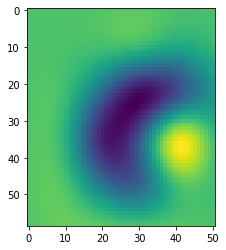

In [103]:
plt.imshow(field[15, :, :, 2])

In [110]:
# Write the registered mesh

movingMeshPath = 'movingMeshRigidRegistered.vtk'
movingMesh = itk.meshread(movingMeshPath)

for i in range(0, movingMesh.GetNumberOfPoints()):
    movingMesh.SetPoint(i, final_transform.TransformPoint(movingMesh.GetPoint(i)))

w1 = itk.MeshFileWriter[type(movingMesh)].New()
w1.SetFileName('movingMeshFinalRegistered.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(movingMesh)
w1.Update()

In [121]:
print('Calculating distance between landmarks')

MOVING_LANDMARK_FILE = '/data/Apedata/CorrectData/data/Gorilla/landmarks/USNM176211_LM1.fcsv'
moving_landmark = read_landmarks(MOVING_LANDMARK_FILE)

mesh_moving_landmark = itk.Mesh[itk.D, 3].New()
mesh_moving_landmark.SetPoints(itk.vector_container_from_array(moving_landmark.flatten().astype('float32')))

# mesh_moving_landmark = itk.transform_mesh_filter(
#         mesh_moving_landmark, transform=first_transform)

# mesh_moving_landmark = itk.transform_mesh_filter(
#         mesh_moving_landmark, transform=second_transform)

# mesh_moving_landmark = itk.transform_mesh_filter(
#         mesh_moving_landmark, transform=final_transform)

# moving_landmark = itk.array_from_vector_container(mesh_moving_landmark.GetPoints())


Calculating distance between landmarks


In [176]:
m1 = np.load('moving_landmark.npy')
f1 = np.load('fixed_landmark.npy')

In [190]:
diff = m1 - f1
print(diff[0])

diff = np.square(diff)
print(diff[0])

diff = np.sum(diff, 1)
print(diff[0])

diff = np.sqrt(diff)
print(diff[0])
#np.save('diff_landmark.npy', diff)

[ 0.4483719 -1.8825657 14.140598 ]
[  0.20103735   3.5440538  199.95653   ]
203.70161
14.272408


In [183]:
print(m1[0])
print(f1[0])
print(d1[0])

[ 30.944654  -4.54917  -33.18866 ]
[ 30.496283   -2.6666043 -47.329258 ]
14.272408


In [182]:
t1 = m1[0] - f1[0]
print(t1)
print(np.square(t1))
print(np.sum(t1, 0))

[ 0.4483719 -1.8825657 14.140598 ]
[  0.20103735   3.5440538  199.95653   ]
12.706405


In [175]:
d1 = np.load('diff_landmark.npy')
print('mean distance ', np.mean(d1))
print(d1)

mean distance  52.08045
[ 14.272408   14.889301    5.056721    6.3611655   4.494349    1.9340465
  14.155607   19.130554   17.783134   34.389854   33.564537   37.1145
  39.824654   52.30405    55.192547   79.7469     82.44674    10.079343
  15.504842   31.699604   12.659089   68.35028    66.24091   112.576004
 109.66682    29.8028     33.345787   62.146427   68.75282   158.61354
 155.37991   127.32826   127.8302     65.01265    64.65288    37.853184
  39.87145    40.615364   38.040062   73.58407    73.03103  ]


In [ ]:
# 52.801685 -> numberOfGridNodesInOneDimension = 10, numOfIterations = 2500, maxStep = 0.2, learningRate = 0.2

In [197]:
import glob

allfiles = glob.glob('/data/Apedata/CorrectData/data/Gorilla/meshes/*.ply')
allnames = []

for x in allfiles:
    if '-' in x:
        allnames.append(x.split('/')[-1].split('-')[0])
    else:
        allnames.append(x.split('/')[-1].split('_')[0])

print(len(allnames))
print(allnames.remove('USNM176211'))
print(len(allnames))
print(allnames)

allnames = ["USNM174715"]

22
None
21
['USNM582726', 'USNM590951', 'USNM599165', 'USNM590953', 'USNM252577', 'USNM590947', 'USNM599167', 'USNM176217', 'USNM297857', 'USNM252575', 'USNM174715', 'USNM220324', 'USNM176216', 'USNM590954', 'USNM252580', 'USNM220060', 'USNM252578', 'USNM176209', 'USNM599166', 'USNM590942', 'USNM174722']
